# Классификация дефектов кожи

In [ ]:
#!pip install -q tensorflow==2.3
#!pip install keras_efficientnets
#!pip freeze > requirements.txt

# Импортируем библиотеки 

In [38]:
# Импортируем библиотеки

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import itertools 

#from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras.layers as L
#from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import albumentations
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#import tensorflow as tf
import tensorflow.keras 
import tensorflow.keras.models #as M
#import tensorflow.keras.layers as L
#import tensorflow.keras.backend #as K
from tensorflow.keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
from glob import iglob
#from keras.applications import InceptionV3
#from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense ,LeakyReLU,GlobalAveragePooling2D, BatchNormalization,GlobalMaxPool2D

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
#DATA_PATH = "/content/drive/My Drive/cars2/"
#PATH = "/content/"  # рабочая директория

In [7]:
#from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB4
print(keras.__version__)
print(tf.__version__)

2.4.0
2.3.1


In [8]:
print(tf.__version__)

2.3.1


In [9]:
from tensorflow.keras.applications import InceptionV3

In [10]:
keras.applications.EfficientNetB4()

78872576/78864416 [==============================] - 1s 0us/step


In [11]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.17.5
Tensorflow   : 2.3.1


# Задаем константы

In [12]:
train_path = "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
test_path = "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

In [13]:
RANDOM_SEED = 42
#IMAGE_SIZE         = (128, 128)
#INPUT_SHAPE        = (224, 224, 3)
IMG_SIZE           = 299 # размер входного изображения для Xception по-умолчанию
IMG_CHANNELS       = 3   # у RGB 3 канала
input_shape        = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
# Keras settings
BATCH_SIZE = 6
VAL_BATCH_SIZE = 8
VAL_SPLIT          = 0.2 # сколько данных выделяем на тест = 15%
EPOCHS = 6
LR = 0.00001

# Предобработка изображений: просмотр, аугментация, создание обучающего и тестового наборов

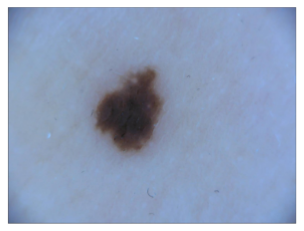

In [14]:
# Посмотрим пример картинки

img = PIL.Image.open(train_path + "nevus/ISIC_0000041.jpg") # load_img(train_path + "nevus/ISIC_0000041.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()


In [15]:
# Преобразуем картинку в массив

x = img_to_array(img)
print(x.shape)
x

(1129, 1504, 3)


array([[[255., 255., 236.],
        [220., 223., 206.],
        [255., 255., 248.],
        ...,
        [255., 255., 250.],
        [223., 219., 207.],
        [255., 255., 239.]],

       [[230., 233., 214.],
        [ 34.,  36.,  23.],
        [  5.,   7.,   2.],
        ...,
        [  7.,   3.,   2.],
        [ 36.,  32.,  23.],
        [233., 230., 215.]],

       [[255., 255., 244.],
        [  0.,   2.,   0.],
        [  0.,   1.,   2.],
        ...,
        [  1.,   0.,   4.],
        [  3.,   0.,   0.],
        [255., 255., 248.]],

       ...,

       [[251., 245., 245.],
        [  3.,   0.,   0.],
        [  1.,   0.,   0.],
        ...,
        [  0.,   1.,   0.],
        [  0.,   1.,   0.],
        [248., 250., 247.]],

       [[255., 254., 250.],
        [  9.,   4.,   1.],
        [  3.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  3.,   4.,   0.],
        [255., 255., 250.]],

       [[255., 254., 250.],
        [255., 254., 250.],
        [255., 2

In [16]:
# C помощью glob определяем сколько разных папок с картинками имеется.

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  9


## Аугментация с помощью ImageDataGenerator (выполняется либо этот раздел аугментации, либо следующий )

In [56]:
# Аугментация обучающего датасета
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 60,
    brightness_range = [0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    fill_mode='reflect')  #  fill_mode='nearest'

       
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [57]:
# Завернем наши данные в генератор.

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 1571 images belonging to 9 classes.
Found 668 images belonging to 9 classes.


In [58]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)


Found 118 images belonging to 9 classes.


In [44]:
train_generator

## Аугментация с помощью albumentations (выполняется либо этот раздел аугментации, либо предыдущий)

In [17]:
!pip install albumentations

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [18]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-m_zntl9g
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29530 sha256=ff1cf6aa11460c8e5de6bea4348c57204f778cf804ea287f0839207753046e6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-a3xd_z5p/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [19]:
import albumentations
import cv2
from ImageDataAugmentor.image_data_augmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [20]:
# попробовать

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(), #0.5
    albumentations.Rotate(limit=40),
    albumentations.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RandomContrast(limit=0.2, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [252]:
# Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.


AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=299, width=299),
        albumentations.CenterCrop(height=299, width=299),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
   # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [21]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data



/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [79]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 118 images belonging to 9 classes.


Пример картинок из train_generator


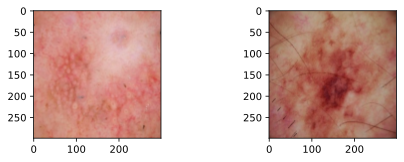

In [22]:
# Прсмотрим несколько картинок после применения аугментации.

from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,2):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [23]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)

(6, 299, 299, 3) (6, 9)


# Посмотрим распределение данных по классам.

In [24]:

def classes_count (path):
    # определяет содержимое папок классов
    
    classes = []
    for filename in iglob(os.path.join(train_path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])
    cnt = Counter(classes)
    return cnt

def percentage_value(pct, allvals):
    # вычисляет процентное значение размера класса
    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    # строит круговую диаграмму
    
    classes_cnt = classes_count(path)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

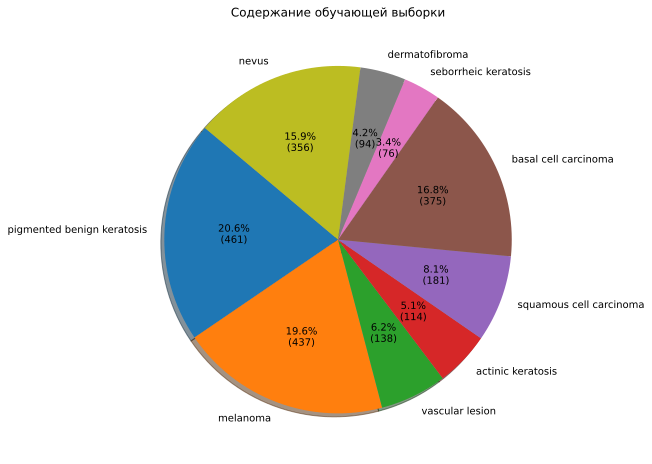

In [25]:
plot_dataset_description(os.path.join(train_path), "Содержание обучающей выборки")

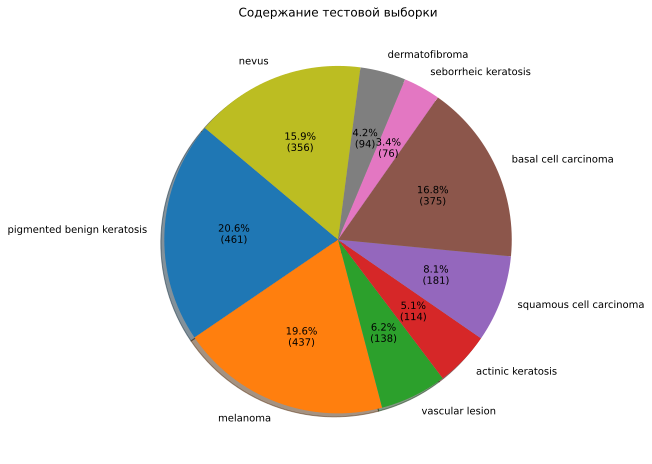

In [75]:
plot_dataset_description(os.path.join(test_path), "Содержание тестовой выборки")

In [32]:
def plot_dataset_description_bar(path, title):
    # строит диаграмму столбиками
 
    classes_val = classes_count(path)

    values = list(classes_val.values())
    labels = list(classes_val.keys())

    index = [n for n in range(numberOfClass)]
    plt.figure(figsize=(10, 5))
    #hist, bins = np.histogram(values, bins=9)
    plt.bar(values, values, width=10)
    
    #plt.xlabel('Градация болезней', fontsize=10)
    plt.ylabel('Количество картинок', fontsize=10)
    plt.xticks(values, labels, fontsize=8, rotation=90)
    plt.title(title)

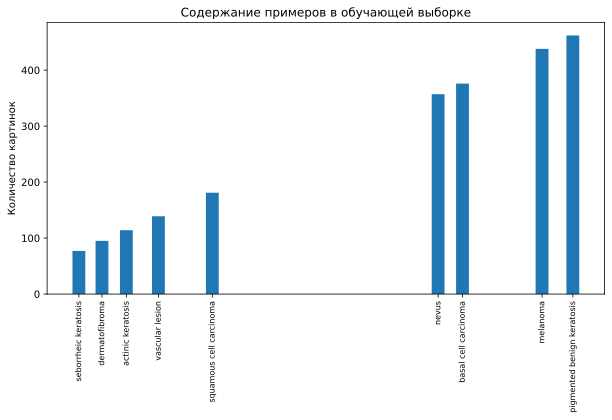

In [33]:
plot_dataset_description_bar(os.path.join(test_path), 'Содержание примеров в обучающей выборке')

# t-SNE

In [320]:
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(4, 2)

In [321]:
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

In [324]:
datasets.info()

AttributeError: module 'sklearn.datasets' has no attribute 'info'

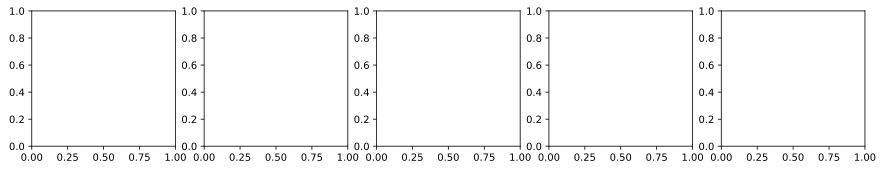

In [318]:
n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(1, 5, figsize=(15, 2.5))

ValueError: `n_samples` can be either an int or a two-element tuple.

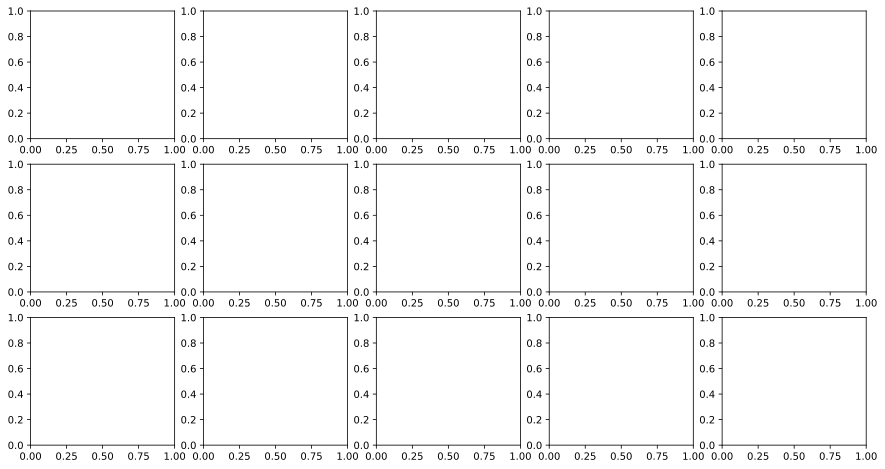

In [331]:

n_samples = 300
n_components = 3
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(n_samples=x, factor=.5, noise=.05)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

# Another example using s-curve
X, color = datasets.make_s_curve(n_samples, random_state=0)

ax = subplots[1][0]
ax.scatter(X[:, 0], X[:, 2], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
X = np.hstack([
    xx.ravel().reshape(-1, 1),
    yy.ravel().reshape(-1, 1),
])
color = xx.ravel()
ax = subplots[2][0]
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


plt.show()

# Построение модели.

In [65]:
def modelXception():
    
    model = Sequential()
    model.add(Xception(include_top = False, weights = "imagenet",  # Xception ResNet50 VGG19 NASNetLarge InceptionResNetV2  InceptionV3 28 EfficientNetB4
                            input_shape=(IMG_SIZE,IMG_SIZE, 3)))
    #model.add(GlobalAveragePooling2D())
    #model.add(BatchNormalization())   # переобучение
    ###model.add(Dense(128, activation = 'relu'))
    ##model.add(LeakyReLU(0.0001))
    ##model.add(Dropout(0.2))
    ###model.add(BatchNormalization())
    #model.add(Dense(256, activation='relu'))
    model.add(GlobalMaxPool2D())  
    model.add(Dropout(0.5))
    model.add(Dense(numberOfClass, activation = "softmax"))
    
    return model 

In [35]:
numberOfClass
MaxPooling2D()

In [24]:
imgs, labels = next(test_generator)
print(imgs.shape, labels.shape)

(6, 299, 299, 3) (6, 9)


In [36]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)

(6, 299, 299, 3) (6, 9)


In [67]:
model = modelXception()

In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 18441     
Total params: 20,879,921
Trainable params: 20,825,393
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
from tensorflow.keras import utils

utils.plot_model(model)

In [ ]:
#model = Sequential()
#model.add(InceptionV3(include_top=False, weights='imagenet',input_shape=(3,299,299)))
#model.add(Flatten(input_shape=(3,299,299)[1:]))
#model.add(Dense(32))
#model.add(LeakyReLU(0.001))
#model.add(Dense(16))
#model.add(LeakyReLU(0.001))
#model.add(Dense(numberOfClass, activation='softmax'))
#model.layers[0].trainable = False1129, 1504, 3)

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
#model.summary()

In [70]:
# CallBack для сохранения модели, ее весов и лучшей модели
weightpath = "best_model.hdf5"
checkpoint = ModelCheckpoint(weightpath , monitor = ['val_accuracy'] , mode = 'max', verbose = 1 ) #save_weights_only=True, save_best_only=True,
#checkpoint = ModelCheckpoint(weightpath , monitor = ['val_accuracy'] , save_best_only=True)
reducer = ReduceLROnPlateau(monitor='loss', patience= 3,factor=0.75, min_lr=0.0000001,  verbose = 1)
early_stop= EarlyStopping(monitor='loss',patience= 7, min_delta=0.000000001, mode='min')

In [71]:
# EarlyStopping для остановки обучения, когда отслеживаемый показатель перестал улучшаться.

#early_stop= EarlyStopping(min_delta=0.001, verbose=1, mode="max", restore_best_weights=False) #  patience=7,

#callbacks_list = [checkpoint] #, early_stop]
callbacks_list = [checkpoint, reducer, early_stop]

In [72]:
# Компилируем модель.

model.compile(optimizer=optimizers.Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
len(train_generator)

300

In [36]:
train_generator.samples

1795

# Обучаем модель.

In [73]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 38, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/38
300/300 [==============================] - ETA: 0s - loss: 3.1540 - accuracy: 0.1532
Epoch 00001: saving model to best_model.hdf5
300/300 [==============================] - 67s 224ms/step - loss: 3.1540 - accuracy: 0.1532 - val_loss: 1.9966 - val_accuracy: 0.2613
Epoch 2/38
300/300 [==============================] - ETA: 0s - loss: 2.0854 - accuracy: 0.2206
Epoch 00002: saving model to best_model.hdf5
300/300 [==============================] - 67s 222ms/step - loss: 2.0854 - accuracy: 0.2206 - val_loss: 1.9514 - val_accuracy: 0.3176
Epoch 3/38
300/300 [==============================] - ETA: 0s - loss: 2.0096 - accuracy: 0.2591
Epoch 00003: saving model to best_model.hdf5
300/300 [==============================] - 66s 221ms/step - loss: 2.0096 - accuracy: 0.2591 - val_loss: 1.8956 - val_accuracy: 0.3581
Epoch 4/38
300/300 [==============================] - ETA: 0s - loss: 1.9306 - accuracy: 0.2903
Epoch 00004: saving model to best_model.hdf5
300/300 [=========================

Epoch 31/38
300/300 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.7933
Epoch 00031: saving model to best_model.hdf5
300/300 [==============================] - 66s 222ms/step - loss: 0.5608 - accuracy: 0.7933 - val_loss: 1.0975 - val_accuracy: 0.6239
Epoch 32/38
300/300 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.7961
Epoch 00032: saving model to best_model.hdf5
300/300 [==============================] - 66s 222ms/step - loss: 0.5693 - accuracy: 0.7961 - val_loss: 1.1191 - val_accuracy: 0.6261
Epoch 33/38
300/300 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.8117
Epoch 00033: saving model to best_model.hdf5
300/300 [==============================] - 66s 221ms/step - loss: 0.5274 - accuracy: 0.8117 - val_loss: 1.1680 - val_accuracy: 0.6194
Epoch 34/38
300/300 [==============================] - ETA: 0s - loss: 0.5365 - accuracy: 0.8017
Epoch 00034: saving model to best_model.hdf5
300/300 [=====================

In [ ]:
#print("Straturi:")
#for i, layer in enumerate(model.layers[:30]):
#    print(i, layer.name)
#    layer.trainable = False

In [74]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last.hdf5')
model.load_weights('best_model.hdf5')

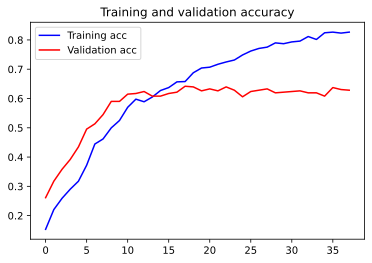

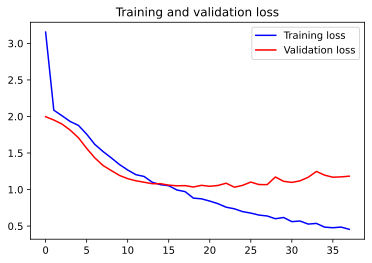

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

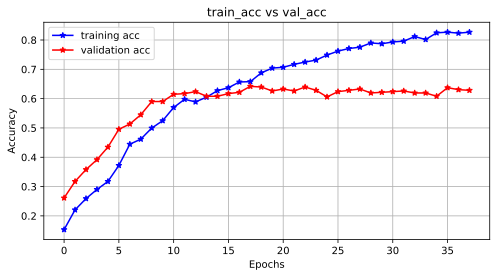

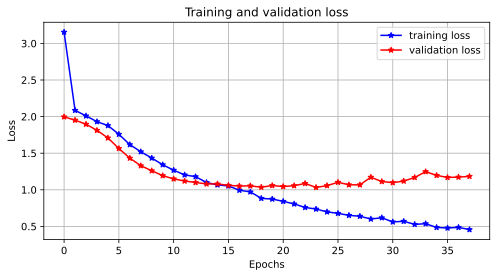

In [76]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], 'b*-', label="training acc")
plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
plt.grid()
plt.title("train_acc vs val_acc")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], 'b*-', label="training loss")
plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
plt.grid()
plt.title("Training and validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Результаты

In [77]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

74/74 [==============================] - 9s 125ms/step - loss: 1.1830 - accuracy: 0.6284
Accuracy: 62.84%


In [80]:
scores = model.evaluate_generator(test_val_generator, steps=len(test_val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

20/20 [==============================] - 11s 551ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Accuracy: 0.00%


In [80]:
scores

[55.505340576171875, 0.19610778987407684]

In [81]:
scores2 = model.predict(test_val_generator)  #np.argmax(probabilities)

In [82]:
scores2

array([[0.0000000e+00, 6.9716982e-10, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 3.9451047e-28],
       [0.0000000e+00, 3.1123867e-10, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 6.2575390e-28],
       [0.0000000e+00, 5.0625903e-10, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 3.2340452e-28],
       ...,
       [0.0000000e+00, 4.7271403e-10, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 5.8772030e-28],
       [0.0000000e+00, 3.2035624e-10, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.1939481e-28],
       [0.0000000e+00, 3.0093419e-10, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.2864781e-28]], dtype=float32)

In [ ]:
scores = model.evaluate_generator(scores2, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

## Confugn matrix по тестовым данным

In [82]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1)  # test_val_generator
Y_pred

74/74 [==============================] - 10s 141ms/step
CPU times: user 12.1 s, sys: 504 ms, total: 12.6 s
Wall time: 11.4 s


array([[2.4801218e-05, 1.3071760e-04, 9.4945572e-05, ..., 1.8893712e-03,
        3.8446392e-06, 4.3953308e-03],
       [9.7872093e-02, 2.8696809e-02, 1.3577333e-02, ..., 3.5469398e-02,
        6.6013789e-01, 7.8550661e-03],
       [3.0589790e-06, 3.4774865e-07, 5.2689218e-05, ..., 2.0120027e-05,
        4.5904508e-06, 6.2947890e-07],
       ...,
       [7.0708420e-04, 5.6647420e-01, 7.4456399e-04, ..., 5.5878212e-05,
        1.7585033e-01, 2.6127223e-05],
       [1.8906232e-03, 6.9711134e-03, 2.4042769e-04, ..., 1.4223544e-01,
        1.2940141e-02, 9.8313365e-05],
       [5.5694720e-04, 2.4646537e-03, 1.8059801e-03, ..., 2.1924837e-03,
        3.0125992e-02, 1.3180885e-04]], dtype=float32)

In [83]:
y_pred2 = np.argmax(Y_pred, axis=1)
y_pred2

array([4, 7, 4, 3, 5, 3, 7, 1, 8, 7, 5, 1, 4, 5, 1, 5, 5, 3, 3, 4, 1, 5,
       1, 5, 8, 5, 4, 5, 7, 5, 1, 5, 7, 5, 3, 1, 1, 4, 8, 5, 1, 4, 5, 5,
       2, 1, 1, 7, 4, 1, 4, 2, 1, 7, 1, 7, 4, 3, 1, 5, 7, 4, 7, 3, 4, 7,
       8, 8, 5, 1, 5, 2, 2, 2, 0, 4, 1, 5, 5, 3, 2, 5, 1, 5, 1, 4, 4, 1,
       5, 8, 7, 4, 3, 1, 4, 7, 8, 4, 7, 3, 5, 3, 4, 4, 5, 1, 5, 1, 3, 4,
       3, 1, 4, 5, 1, 7, 5, 1, 3, 2, 0, 1, 3, 7, 1, 1, 4, 5, 2, 5, 4, 4,
       2, 7, 7, 5, 5, 4, 8, 5, 5, 2, 5, 1, 4, 3, 8, 5, 4, 4, 4, 4, 4, 1,
       4, 5, 5, 1, 5, 0, 1, 4, 5, 2, 3, 1, 5, 5, 1, 4, 3, 8, 1, 1, 3, 4,
       2, 3, 3, 1, 1, 1, 3, 4, 8, 5, 5, 5, 3, 1, 1, 5, 3, 4, 5, 4, 1, 4,
       1, 8, 5, 1, 4, 4, 1, 5, 4, 5, 4, 7, 4, 3, 4, 3, 5, 1, 1, 3, 5, 4,
       4, 4, 1, 5, 1, 2, 3, 1, 4, 4, 3, 1, 4, 4, 4, 5, 1, 4, 4, 4, 4, 1,
       7, 4, 5, 8, 0, 5, 3, 1, 5, 4, 3, 5, 5, 1, 1, 1, 4, 8, 4, 5, 4, 3,
       7, 4, 7, 3, 4, 8, 2, 4, 7, 5, 4, 4, 8, 4, 4, 4, 1, 1, 3, 4, 1, 4,
       3, 3, 5, 3, 8, 4, 2, 4, 5, 4, 8, 3, 5, 7, 3,

In [84]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred2)

In [85]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [86]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


In [ ]:
list(classes.values())

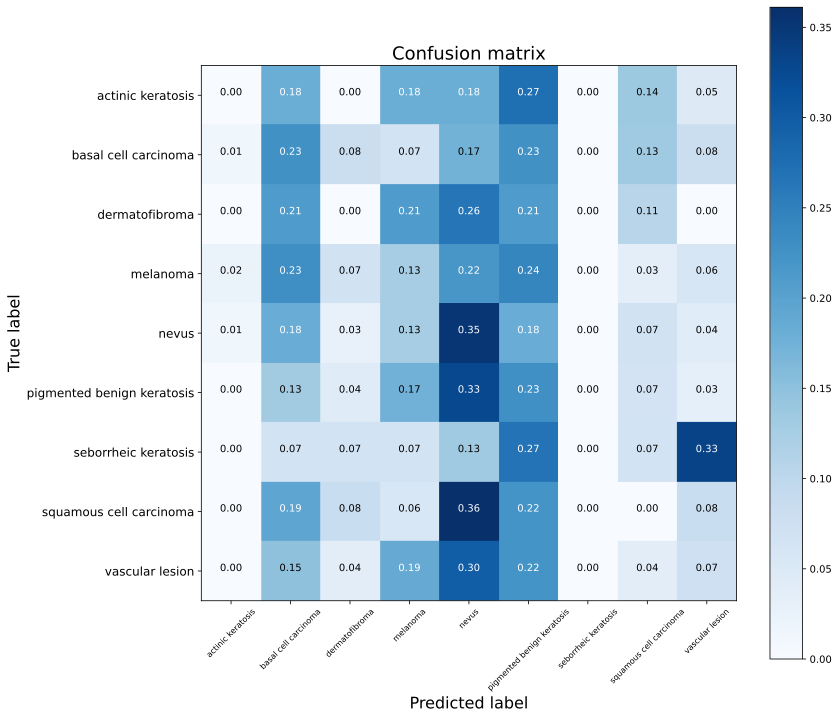

In [87]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [88]:
# классификация ответов

print(classification_report(test_generator.classes, y_pred2, target_names=list(classes.values())))

                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        22
      basal cell carcinoma       0.21      0.23      0.22        75
            dermatofibroma       0.00      0.00      0.00        19
                  melanoma       0.19      0.13      0.15        87
                     nevus       0.21      0.35      0.26        71
pigmented benign keratosis       0.21      0.23      0.22        92
      seborrheic keratosis       0.00      0.00      0.00        15
   squamous cell carcinoma       0.00      0.00      0.00        36
           vascular lesion       0.07      0.07      0.07        27

                  accuracy                           0.17       444
                 macro avg       0.10      0.11      0.10       444
              weighted avg       0.15      0.17      0.16       444



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confugn matrix по валидационным данным

In [89]:
%%time
Y_pred1 = model.predict_generator(test_val_generator,verbose=1)  # test_val_generator
y_pred_val = np.argmax(Y_pred1, axis=1)
y_pred_val

20/20 [==============================] - 8s 414ms/step
CPU times: user 8.22 s, sys: 1.02 s, total: 9.24 s
Wall time: 8.46 s


array([4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 0, 4, 4, 1, 1, 1, 1, 1, 5,
       5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 2, 2, 2, 5, 4, 2, 1, 2, 2, 2,
       2, 2, 2, 7, 4, 4, 3, 4, 4, 4, 5, 5, 4, 4, 5, 4, 3, 4, 4, 5, 3, 4,
       4, 5, 5, 4, 4, 4, 4, 4, 1, 4, 4, 3, 4, 4, 5, 1, 5, 5, 5, 5, 5, 5,
       3, 5, 5, 5, 1, 5, 4, 1, 3, 3, 3, 4, 3, 3, 3, 1, 1, 7, 7, 7, 5, 1,
       7, 5, 7, 5, 7, 8, 8, 8])

In [90]:
cnf_matrix_val = confusion_matrix(test_val_generator.classes, y_pred_val)
classes = {v: k for k, v in test_val_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


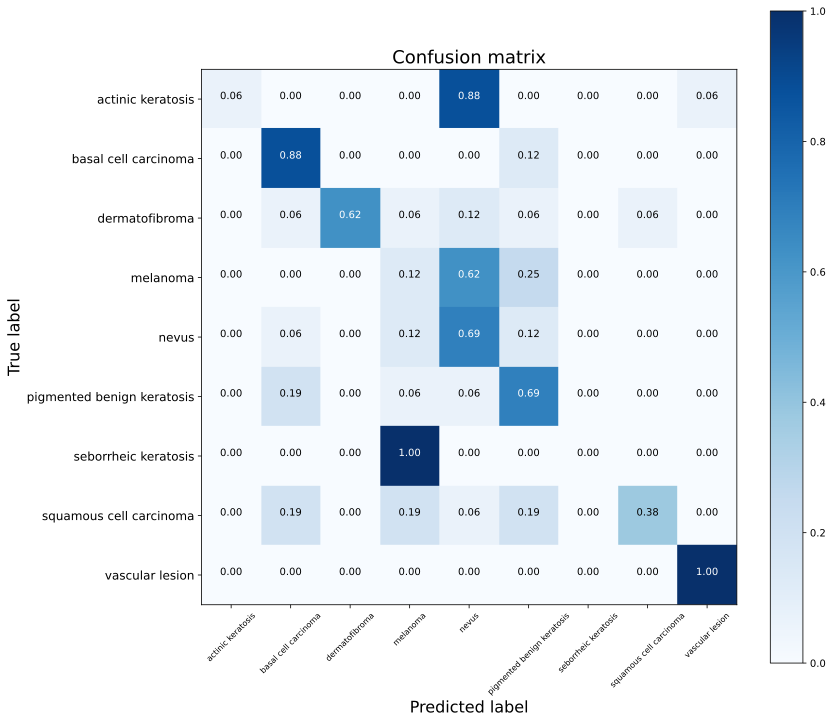

In [91]:
plot_confusion_matrix(cnf_matrix_val, list(classes.values()))

In [92]:
# классификация ответов

print(classification_report(test_val_generator.classes, y_pred_val, target_names=list(classes.values())))

                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.06      0.12        16
      basal cell carcinoma       0.64      0.88      0.74        16
            dermatofibroma       1.00      0.62      0.77        16
                  melanoma       0.17      0.12      0.14        16
                     nevus       0.28      0.69      0.40        16
pigmented benign keratosis       0.48      0.69      0.56        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.86      0.38      0.52        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.49       118
                 macro avg       0.57      0.49      0.46       118
              weighted avg       0.62      0.49      0.46       118



# Tестовая демонстрация.

In [93]:
def load_image(filename):
    # загружает картинку
    
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    return img

def predict(image):
    # возвращает первые три максимальных значений из предсказанных для каждого класса
    
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = (-probabilities).argsort()[:3]  # np.argmax(probabilities)
    return class_idx, probabilities[class_idx]

In [94]:
img2=load_image('/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'+'vascular lesion/ISIC_0025707.jpg')

NameError: name 'IMAGE_SIZE' is not defined

In [95]:
pr = model.predict(img3)[0]

NameError: name 'img3' is not defined

In [ ]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 3)):    # test_val_generator
    print("Источник: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][0]], prediction[1][0]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][1]], prediction[1][1]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][2]], prediction[1][2]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

# Сохранение модели для продакшн

In [97]:
import pickle
from multiprocessing import Pool, Value, Queue
import multiprocessing
model_prod = pickle.dumps(history)
type(model_prod), type(history)

TypeError: can't pickle _thread.RLock objects

In [98]:
with open('myfile.pkl', 'wb') as output:
       pickle.dump(history, output)

TypeError: can't pickle _thread.RLock objects

In [ ]:
with open('myfile.pkl', 'rb') as pkl_file:
    regressor = pickle.load(pkl_file)